In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import polars as pl
import numpy as np

from adex.models import Condition, ConditionDataLoader, ConditionSequencingTissueDataLoader, \
    ConditionSequencingDataLoader, SequencingTechnique, TissueEnum, METADATA_COLUMNS, FileDataLoader, DataLoader
from adex.helpers import get_pre_processed_dataset, run_ml_model
from adex.models import DATASET_INFO_COLUMNS
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score

data_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"
results_path = "../results"

# Prepare Data

In [2]:
top10_de_genes_ra_GSE89408 = (
    pl
    .read_csv(f"../data/ml/GSE89408_top_de_train_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
len(top10_de_genes_ra_GSE89408)

10

In [3]:
de_GSE89408 = (
    get_pre_processed_dataset(
        data_loader=FileDataLoader(
            condition=Condition.RA,
            file_name="GSE89408.tsv.parquet",
            genes=top10_de_genes_ra_GSE89408
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .drop(filter(lambda item: item != 'Condition',METADATA_COLUMNS)) # We need only the condition from Metadata  
    .drop(DATASET_INFO_COLUMNS)
    .with_columns(
        pl.col("Condition")
            .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
            .alias("class_label")
    )
    .drop("Condition")
).sort("Sample")  # Remove randomness at this point 
de_GSE89408

Sample,U62317.1,AL139099.1,AC068631.2,AC025259.1,HSPE1-MOB4,HOXC-AS1,AC020909.4,AC017083.2,AC211429.1,AC025423.4,class_label
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8
"""GSM2370970""",0.0,0.0,5.322358,0.0,0.0,7.776255,0.0,0.0,6.472111,0.0,0
"""GSM2370971""",0.0,7.078922,1.326442,6.073492,6.562024,5.827561,5.274107,7.938222,3.094096,7.707919,0
"""GSM2370972""",0.858757,0.0,2.341239,0.0,0.0,5.136107,3.808962,7.53651,3.056805,6.148911,0
"""GSM2370973""",1.069102,3.11884,0.0,0.0,0.0,5.965672,0.0,0.0,5.131011,5.776321,0
"""GSM2370974""",0.0,0.0,1.963042,0.0,0.0,6.059763,3.860753,5.758763,4.70726,4.476259,0
…,…,…,…,…,…,…,…,…,…,…,…
"""GSM2371183""",2.794609,8.181333,6.175148,5.721076,6.852084,4.167273,4.979133,7.564782,2.606461,7.378751,1
"""GSM2371184""",3.255327,10.372098,7.60949,4.777353,8.125291,1.352949,7.544912,8.341194,2.288607,7.99071,1
"""GSM2371185""",3.103816,9.312345,5.154133,5.047704,6.937231,3.772043,6.416332,7.450259,3.772043,8.041741,1


In [4]:
de_GSE89408.select(pl.col("class_label").value_counts()) # Imbalanced data between the two classes

class_label
struct[2]
"{1,152}"
"{0,28}"


In [5]:
x_df = (
        de_GSE89408.select([
            pl.all().exclude("Sample", "class_label"),
        ]).to_pandas()
 )
x_df

,U62317.1,AL139099.1,AC068631.2,AC025259.1,HSPE1-MOB4,HOXC-AS1,AC020909.4,AC017083.2,AC211429.1,AC025423.4
0,0.000000,0.000000,5.322358,0.000000,0.000000,7.776255,0.000000,0.000000,6.472111,0.000000
1,0.000000,7.078922,1.326442,6.073492,6.562024,5.827561,5.274107,7.938222,3.094096,7.707919
2,0.858757,0.000000,2.341239,0.000000,0.000000,5.136107,3.808962,7.536510,3.056805,6.148911
3,1.069102,3.118840,0.000000,0.000000,0.000000,5.965672,0.000000,0.000000,5.131011,5.776321
4,0.000000,0.000000,1.963042,0.000000,0.000000,6.059763,3.860753,5.758763,4.707260,4.476259
...,...,...,...,...,...,...,...,...,...,...
175,2.794609,8.181333,6.175148,5.721076,6.852084,4.167273,4.979133,7.564782,2.606461,7.378751
176,3.255327,10.372098,7.609490,4.777353,8.125291,1.352949,7.544912,8.341194,2.288607,7.990710
177,3.103816,9.312345,5.154133,5.047704,6.937231,3.772043,6.416332,7.450259,3.772043,8.041741
178,2.795792,10.422702,6.608690,5.986713,6.764702,3.197420,6.813169,7.930536,0.000000,7.969548


In [6]:
y_df = de_GSE89408.select(pl.col("class_label").alias("y")).to_pandas()
y_df

,y
0,0
1,0
2,0
3,0
4,0
...,...
175,1
176,1
177,1
178,1


In [7]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_df, y_df, 
    train_size=0.7, 
    random_state=42,  # Ensure a reproducible split 
    shuffle=True, 
    stratify=y_df  # solve the class imbalance issue 
)

In [8]:
x_train

,U62317.1,AL139099.1,AC068631.2,AC025259.1,HSPE1-MOB4,HOXC-AS1,AC020909.4,AC017083.2,AC211429.1,AC025423.4
13,1.864341,0.000000,3.828335,0.000000,0.000000,6.532242,0.000000,0.000000,5.213109,4.348193
73,5.518350,10.635017,7.227001,6.062215,6.102829,2.267737,6.487267,7.122238,2.749214,6.921170
4,0.000000,0.000000,1.963042,0.000000,0.000000,6.059763,3.860753,5.758763,4.707260,4.476259
5,3.491997,7.339339,0.000000,0.000000,0.000000,4.619271,3.617796,5.965939,3.031357,7.195406
57,3.369568,9.256971,0.000000,3.841646,0.000000,3.544659,5.534341,5.156864,0.000000,6.887080
...,...,...,...,...,...,...,...,...,...,...
53,4.026287,6.324991,6.967549,3.321436,6.492915,0.925741,6.189286,7.649072,2.677611,7.152249
64,3.523430,9.004779,5.483675,4.857842,5.741325,3.820045,5.764730,7.112296,1.857876,7.582939
176,3.255327,10.372098,7.609490,4.777353,8.125291,1.352949,7.544912,8.341194,2.288607,7.990710
89,6.023392,9.491333,6.887744,5.788198,5.833912,0.918027,6.062321,7.224499,3.306743,8.236785


In [9]:
y_train

,y
13,0
73,1
4,0
5,0
57,1
...,...
53,1
64,1
176,1
89,1


In [10]:
y_train.value_counts()

y
1    106
0     19
Name: count, dtype: int64

In [11]:
x_test

,U62317.1,AL139099.1,AC068631.2,AC025259.1,HSPE1-MOB4,HOXC-AS1,AC020909.4,AC017083.2,AC211429.1,AC025423.4
18,1.413181,8.564358,5.692894,4.206642,4.951320,4.331076,5.412135,7.372085,1.805233,6.437239
98,5.039403,7.929231,4.946210,5.287529,0.000000,0.000000,2.618922,8.311990,4.286473,6.781749
166,4.546265,8.646634,6.334043,4.151664,6.744603,3.763433,5.757994,7.457176,2.376680,8.160634
140,3.368290,9.799556,4.693256,5.778389,5.722857,2.038738,6.590038,0.000000,0.000000,6.408358
29,3.565866,6.973673,5.856029,5.316553,6.737572,2.206040,5.471475,7.280784,2.206040,7.305715
90,2.823497,8.490438,5.682767,4.661924,0.000000,2.417373,5.528463,7.198596,1.850073,6.763955
162,3.730405,9.872784,6.923948,5.380375,7.737913,3.238416,7.111682,8.126394,1.722972,7.445874
105,4.859096,8.922993,3.460481,0.000000,2.322852,0.000000,5.524691,5.615841,3.001010,5.171047
74,3.025182,0.000000,6.345800,5.838809,6.407781,1.477789,4.649640,0.000000,0.000000,0.000000
45,4.430082,9.390506,5.871831,6.578365,5.766810,3.205202,4.124789,7.258533,0.000000,6.697451


In [12]:
y_test

,y
18,0
98,1
166,1
140,1
29,1
90,1
162,1
105,1
74,1
45,1


In [13]:
y_test.value_counts()

y
1    46
0     9
Name: count, dtype: int64

# Logistic Regression 

Default Parameters of Base Model: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Scores (cv=4): 0.96875,1.0,0.967741935483871,0.9032258064516129
Cross Validation gives 0.96 accuracy with a standard deviation of 0.04

Metrics on the Test Set:

        Accuracy: 0.9636363

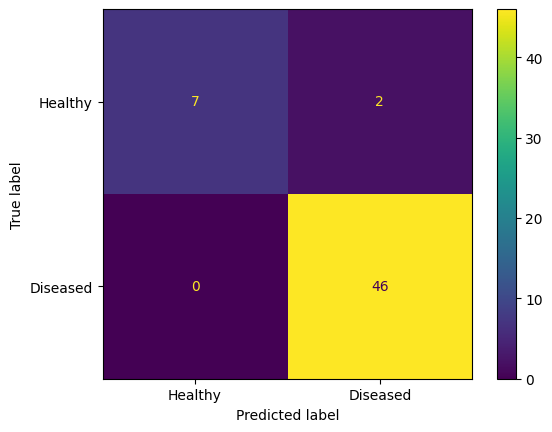

In [15]:
logistic_model, _ = run_ml_model(
    classifier=LogisticRegression(solver='liblinear', random_state=0),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
)

In [16]:
logistic_model.intercept_

array([0.36533388])

In [17]:
logistic_model.coef_

array([[ 0.50805172,  0.07301328,  1.95713103, -0.92784352,  0.994052  ,
        -2.45537137,  0.77690348, -1.18238878, -1.05013509,  1.91002288]])

In [18]:
logistic_model.predict_proba(x_test)

array([[1.09192529e-04, 9.99890807e-01],
       [1.31351863e-04, 9.99868648e-01],
       [1.43144596e-08, 9.99999986e-01],
       [1.95339300e-11, 1.00000000e+00],
       [1.90800787e-08, 9.99999981e-01],
       [4.35920057e-05, 9.99956408e-01],
       [3.04523873e-09, 9.99999997e-01],
       [4.37597983e-08, 9.99999956e-01],
       [2.36383420e-07, 9.99999764e-01],
       [8.59502118e-07, 9.99999140e-01],
       [7.05857595e-12, 1.00000000e+00],
       [1.49340320e-06, 9.99998507e-01],
       [2.83825630e-10, 1.00000000e+00],
       [4.96891417e-12, 1.00000000e+00],
       [5.18520645e-03, 9.94814794e-01],
       [2.72486478e-11, 1.00000000e+00],
       [1.02797643e-08, 9.99999990e-01],
       [9.99999557e-01, 4.42734448e-07],
       [4.81614748e-13, 1.00000000e+00],
       [5.68899639e-09, 9.99999994e-01],
       [1.21093136e-10, 1.00000000e+00],
       [1.12521992e-10, 1.00000000e+00],
       [5.41190896e-04, 9.99458809e-01],
       [5.89084337e-13, 1.00000000e+00],
       [3.656537

# Decision Tree 

Default Parameters of Base Model: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Running with base model
Cross Validation Scores (cv=4): 0.9375,0.9032258064516129,0.9354838709677419,0.9354838709677419
Cross Validation gives 0.93 accuracy with a standard deviation of 0.01

Metrics on the Test Set:

        Accuracy: 0.9272727272727272
        Precision: 0.9375
        Recall: 0.9782608695652174
        f1: 0.9574468085106383
    


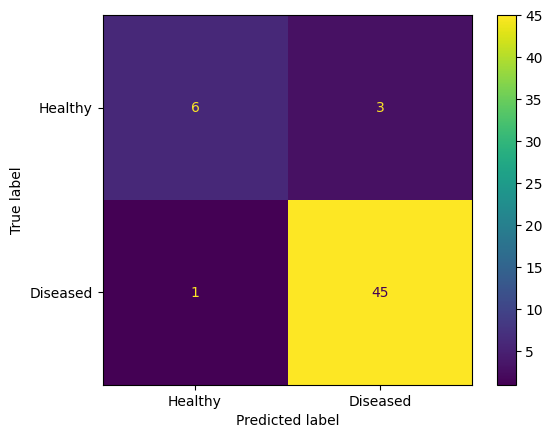

In [19]:
from sklearn import tree

tree_model, _ = run_ml_model(
    classifier=tree.DecisionTreeClassifier(),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

[Text(0.4444444444444444, 0.9, 'x[5] <= 4.54\ngini = 0.258\nsamples = 125\nvalue = [19, 106]'),
 Text(0.2222222222222222, 0.7, 'x[9] <= 2.865\ngini = 0.019\nsamples = 103\nvalue = [1.0, 102.0]'),
 Text(0.1111111111111111, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 102\nvalue = [0, 102]'),
 Text(0.6666666666666666, 0.7, 'x[2] <= 3.89\ngini = 0.298\nsamples = 22\nvalue = [18, 4]'),
 Text(0.5555555555555556, 0.5, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.7777777777777778, 0.5, 'x[4] <= 2.197\ngini = 0.5\nsamples = 8\nvalue = [4, 4]'),
 Text(0.6666666666666666, 0.3, 'x[0] <= 1.998\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.5555555555555556, 0.1, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.7777777777777778, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.8888888888888888, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

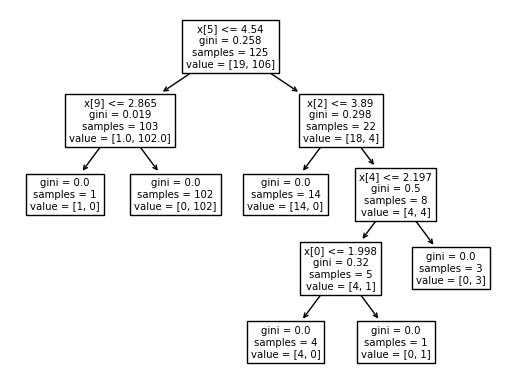

In [20]:
tree.plot_tree(tree_model)

# Gradient boosted Tree

Default Parameters of Base Model: {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Running with base model
Cross Validation Scores (cv=4): 0.96875,0.967741935483871,0.967741935483871,0.8387096774193549
Cross Validation gives 0.94 accuracy with a standard deviation of 0.06

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
        Precision: 0.9583333333333334
        Recall: 1.0
        f1: 0.9787234042553191
    


(HistGradientBoostingClassifier(),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

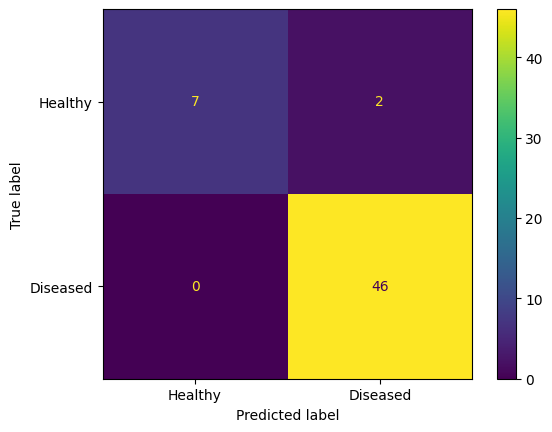

In [21]:
from sklearn.ensemble import HistGradientBoostingClassifier

run_ml_model(
    classifier=HistGradientBoostingClassifier(max_iter=100), 
    x_train=x_train, 
    y_train=y_train, 
    x_test=x_test, 
    y_test=y_test,
)

# Random Forest 

Default Parameters of Base Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Running with base model
Cross Validation Scores (cv=4): 0.9375,1.0,0.9354838709677419,0.9032258064516129
Cross Validation gives 0.94 accuracy with a standard deviation of 0.04

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
        Precision: 0.9583333333333334
        Recall: 1.0
        f1: 0.9787234042553191
    


(RandomForestClassifier(n_estimators=10),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

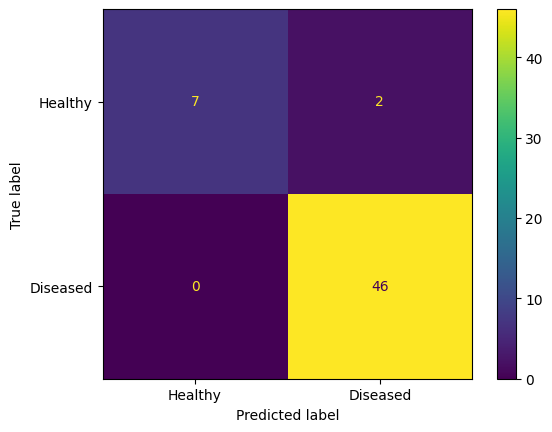

In [22]:
from sklearn.ensemble import RandomForestClassifier

run_ml_model(
    classifier=RandomForestClassifier(n_estimators=10),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

# SVMs

Default Parameters of Base Model: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Running with base model
Cross Validation Scores (cv=4): 0.9375,1.0,0.9354838709677419,0.9354838709677419
Cross Validation gives 0.95 accuracy with a standard deviation of 0.03

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
        Precision: 0.9583333333333334
        Recall: 1.0
        f1: 0.9787234042553191
    


(SVC(),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

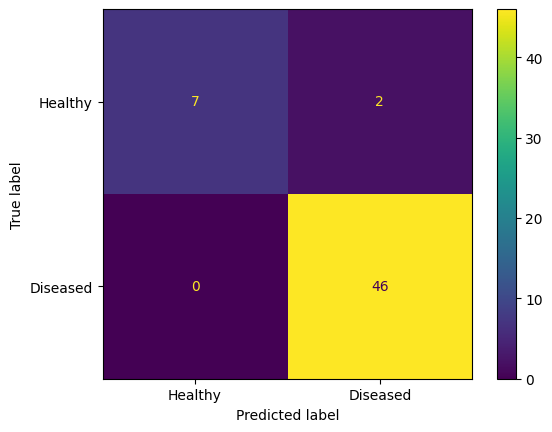

In [23]:
from sklearn import svm

run_ml_model(
    classifier=svm.SVC(),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)